# Generating WOfS images based on gauge readings

This code links gauge data to satellite data and generates an image of water frequency according to a specified level of the water gauge. It reads csv files containing gauge data from the Water Data Online website. You have to go and download the csv file that you're interested in before using this code. It will then generate a duration curve from the csv file. You can then choose which values you are interested in looking at, maybe you want to see what a river looks like at high flow or what a lake looks like at its lowest levels. Enter your latitude and longitude and buffer parameters for the area of which you want to generate an image. Enter the value range for the gauge data that you are interested in. Then press 'Shift'+'Enter' a few times and the code will generate an image of the lat and lon you entered based on the gauge values you gave it. It only takes about 2 minutes to run because it uses Dask to merge the data, it doesn't actually load all the satellite data since 1987. It only loads the data for the specified gauge parameters. So let's go through and see how it does it: 

Start off by importing all the python and datacube modules you need. If you get an error for this box, probably just ignore it and keep going... 

In [1]:
#Just run this box once with 'Shift'+'Enter'. It loads all the things you need to work with the data. 
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'DEAPlotting'

# Enter your latitude and longitude and tell the code where you put your csv file. Below are some lat and lons for areas in the Basin. 

Barmah choke: 
lat = -35.92
lon = 145.00
buffer = 10000

Niemur:
lat = -35.277
lon = 144.3477
buffer = 5500

Macquarie Marshes:
lat = -30.8072
lon = 147.5149
buffer = 10000

Gunbower:
lat = -35.942574
lon = 144.46466
buffer = 10000

Walkool:
lat = -35.1356
lon = 143.6823
buffer = 10000

Murray River at Boundary Bend:
lat = -34.71966901
lon = 143.1698626
buffer = 10000

In [2]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -34.71966901
lon = 143.1698626
buffer = 10000
#Where abouts is your csv file located on your computer?
csv_file_location = '/g/data/r78/kd6095/dea-notebooks/Walkool/Murray_River_Boundary_Bend.csv'

Great, now it's going to re-organise the data in your csv file into a duration curve. Duration curves need an exceedence variable. To make this you have to firsty order the data from highest value to lowest value with the .sort_values() pandas function. You also have to make another column that labels this data 1, 2, 3, 4.. etc, which is like giving each value a rank. I used a numpy function called arange() to do this. Exceedence is equal to 1-(rank/total data points). We also get rid of some of the columns we don't need that just come with the Water Data Online csv files such as Interpolation Type (I don't even know what that is) and Quality Code.  

In [3]:
#Loading and organising guage data
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

Now that the data is organised correctly, it converts the data to an xarray in order for it to be merged with the satellite data later on. Just use the .to_xarray() function for this.

In [4]:
gauge_data_xr = gauge_data.to_xarray()

OK now comes the part where you choose what gauge parameters you want to look at. The next step generates the duration curve we just made, so you can have a look at it and decide what value you might be interested in. It plots the Exceedence column it made earlier against the Value column which might be water level or discharge depending on what kind of csv file you downloaded. 

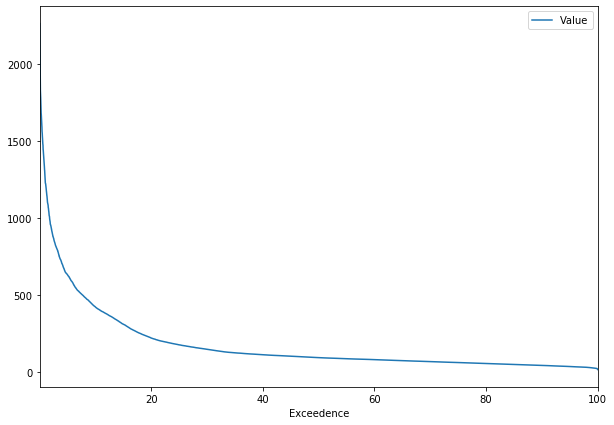

In [5]:
gauge_data.plot(x='Exceedence', y='Value', figsize=(10,7))

In [6]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 800
yaxis_higher_parameter = 2000

The code then Dask loads all of the satellite data for the lat and lon parameters you entered above. Don't worry, this step doesn't take very long to run because it's not ACTUALLY loading all the data, it's just Dask loading it with the dask_chunks = {} command.

In [7]:
#Merging guage data with satellite data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

The gauge data from the csv (xarray version) will now be merged with this Dask loaded wofs_albers data by date using xarray's .interp() function.

In [8]:
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

Great. The code now takes into account the gauge values you wanted to look at. It will retrieve the dates for when the gauge was reading your specified levels and make a list with those dates in it. 

In [9]:
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

It's now going to ACTUALLY load the satellite data, but only for passes in that list it just made. It has to firstly re-do the query for the satellite data. NOTE THAT THE QUERY DOES NOT INCLUDE TIME !!!! Also, let's just quickly check how many data points we are about to load, I would suggest not loading more than 200 passes because it takes a long time to run the loops. If you want less data points, narrow your duration curve parameters.

In [10]:
specified_level.time

<xarray.DataArray 'time' (time: 33)>
array(['1989-09-10T23:47:14.500000000', '1989-09-19T23:40:46.500000000',
       '1989-09-26T23:46:55.500000000', '1989-10-05T23:40:36.500000000',
       '1989-10-12T23:46:27.500000000', '1990-09-06T23:34:49.500000000',
       '1990-09-13T23:41:02.500000000', '1990-09-22T23:34:47.500000000',
       '1990-09-29T23:40:51.500000000', '1990-10-08T23:34:36.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-05T23:42:23.500000000',
       '1992-11-14T23:36:02.500000000', '1992-11-21T23:42:10.500000000',
       '1992-11-30T23:36:08.500000000', '1992-12-07T23:42:25.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-10-07T23:43:26.500000000', '1993-10-16T23:37:11.500000000',
       '1993-10-23T23:43:19.500000000', '1993-11-08T23:43:12.500000000',
       '1993-11-17T23:36:54.500000000', '1993-11-24T23:43:05.500000000',
       '1996-09-06T23:32:16.500000000', '1996-10-31T23:41:19.000000000',
       '1996-1

In [11]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer), 
         'crs': 'EPSG:3577'} 

We don't enter the time part in the query because we want to use that list of times and unfortunately the query will throw an error if you try to give it a list instead of a chronoligical time range. To get around this you have to load each pass individually from the list via a for-loop and concatenate the passes at the end into a new dataset with .concat(). 

In [12]:
#loop selecting data based on FDC parameters
xr_list = []
for date in date_list:
    date = str(date)  
    wofs_albers= dc.load(product = 'wofs_albers', time=date,  **query)
    xr_list.append(wofs_albers)
specified_passes = xr.concat(xr_list, dim='time')

So now it's made a dataset containing only the data you wanted. Great. Now it's going to cloud mask it, ie. it's going to take out any images that are too cloudy to see and only leave you with the clear images. It does this by looping over every data point you loaded in the previous step and analyses the bit flags to see if they are cloud or not. If it has more than 20% cloud bit flags, it gets rid of that image. If it has less than 20% cloud, it keeps that image. You can change the threshold of cloud you are willing to accept, just change the part where it says '20'. 

In [13]:
#Cloud Mask
ClearTimesteps = []
for ix, timestep in enumerate(specified_passes.time):
    SingleTime = specified_passes.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()   
    PercentCloudy = CountClouds.values.item()/(len(specified_passes.x)*len(specified_passes*y))*100
    IsItClearEnough = PercentCloudy <= 20  
    if IsItClearEnough:
        ClearTimesteps.append(ix)     
clear_specified_passes = specified_passes.water.isel(time = ClearTimesteps)


Now it has gathered the clear data, it can generate an image. Remember, we are using Digital Earth Australia's Water Observations from Space dataset. The image that is generated represents how often water was observed when the gauge was at the specified level. If it's yellow it means water was there at every single pass during that level, if it's purple it means water was there maybe just once. White indicates the area was dry in all passes. This part of the code uses WOfS modules from the datacube.

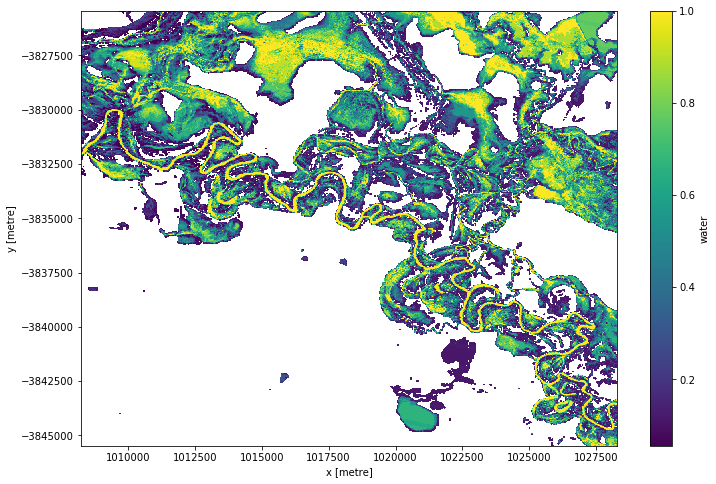

In [14]:
wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows

frequency1 = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

image = frequency1.plot(size=8)
image

Great, there's your image of water frequency according to the gauge reading you wanted. You can check how many satellite passes were used to make this image in the box below. Usually you would want at least 10 passes. 

In [15]:
clear_specified_passes.time

<xarray.DataArray 'time' (time: 18)>
array(['1989-09-19T23:40:46.500000000', '1989-09-26T23:46:55.500000000',
       '1989-10-05T23:40:36.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-30T23:36:08.500000000',
       '1992-12-07T23:42:25.500000000', '1993-01-01T23:36:28.500000000',
       '1993-01-08T23:42:45.500000000', '1993-10-07T23:43:26.500000000',
       '1993-10-16T23:37:11.500000000', '1993-11-17T23:36:54.500000000',
       '1993-11-24T23:43:05.500000000', '2016-11-09T00:17:36.500000000',
       '2016-11-16T00:23:43.500000000', '2016-11-17T00:15:21.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1989-09-19T23:40:46.500000 ... 2016-11-17T00:15:21
Attributes:
    units:    seconds since 1970-01-01 00:00:00